In [19]:
import mne
import sqlite3
%pylab inline

mne.set_log_level('WARNING')

Populating the interactive namespace from numpy and matplotlib


In [28]:
#raw = mne.io.read_raw_brainvision('/Volumes/Store/Avner/POUYAN-BRAIN/pouyan.vhdr')
#raw = mne.io.read_raw_brainvision('/home/avnerus/Code/eegtest/EEG/test2.vhdr')
raw = mne.io.read_raw_eeglab('/Volumes/Store/Avner/MATTI-BRAIN/matti_resampled_500.set')
#raw = mne.io.read_raw_brainvision('/Volumes/Store/Avner/MATTI-BRAIN/matti.vhdr')

print(raw.info)

<Info | 16 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2
    chs : list | 32 items (EEG: 32)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : numpy.ndarray | 1970-01-01 02:00:00
    nchan : int | 32
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    filename : NoneType
    hpi_subsystem : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
>


In [29]:
print((raw.ch_names))

[u'Fp1', u'Fp2', u'F7', u'F3', u'Fz', u'F4', u'F8', u'FC5', u'FC1', u'FC2', u'FC6', u'T7', u'C3', u'Cz', u'C4', u'T8', u'TP9', u'CP5', u'CP1', u'CP2', u'CP6', u'TP10', u'P7', u'P3', u'Pz', u'P4', u'P8', u'PO9', u'O1', u'Oz', u'O2', u'PO10']


In [22]:
events = mne.find_events(raw)

In [23]:
print (events)

[[  361179        0        2]
 [16134604        0        2]]


In [30]:
# Pick the centro-parietal channels
raw.preload = True
centro_parietal_channels = ['C3','Cz','C4','CP1','CP2','CP5','CP6','P3','Pz','P4']
specific_chans = raw.pick_channels(centro_parietal_channels, copy=True)
print(specific_chans)

<RawEEGLAB  |  n_channels x n_times : 10 x 1651660>


In [31]:
first_event_sec = specific_chans.times[361179]
last_event_sec = specific_chans.times[16134604]
print("Experiment times %f --> %f" % (first_event_sec, last_event_sec))

IndexError: index 16134604 is out of bounds for axis 0 with size 1651660

Experiment times 72.235800 --> 3226.920800

In [32]:
#last_event_sec = specific_chans.times[1490754]

#FIRST INDEX WORK AROUND
#pouyan_sec = 48 * 60 + 30.16

#first_event_sec = last_event_sec - pouyan_sec

#print("Total Pouyan time: %f" % (pouyan_sec))
#pouyan_start = indexes[0] - pouyanMs

first_event_sec = 72.235800
last_event_sec = 3226.920800


start, stop = specific_chans.time_as_index([first_event_sec,last_event_sec]) 
print(start,stop)


(36117, 1613460)


In [33]:
specific_chans = specific_chans.load_data()
specific_chans.preload = False
data, times = specific_chans[:, start:stop]
print(specific_chans)

<RawEEGLAB  |  n_channels x n_times : 10 x 1651660>


In [34]:
print(len(data[0]))

1577343


In [35]:
def get_lpp(index):    
    first_index = int(index + raw.info['sfreq'] * 0.4)
    last_index = int(index + raw.info['sfreq'] * 0.7)
    if last_index < len(data[0]):
        #print("Will get maximum value between index %d and %d" % (first_index, last_index))       
        
        max_amplitude = data[:,first_index:last_index + 1].sum(axis=0).max()
        present_value = data[:,index].sum()
        
        lpp  = max_amplitude - present_value
        return lpp
    else:
        return 0
        
lpp_values = []
for i in range(len(data[0])):
    lpp_values.append(get_lpp(i))

               

/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Volumes/Store/Avner/Projects/socialbonds/venv/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


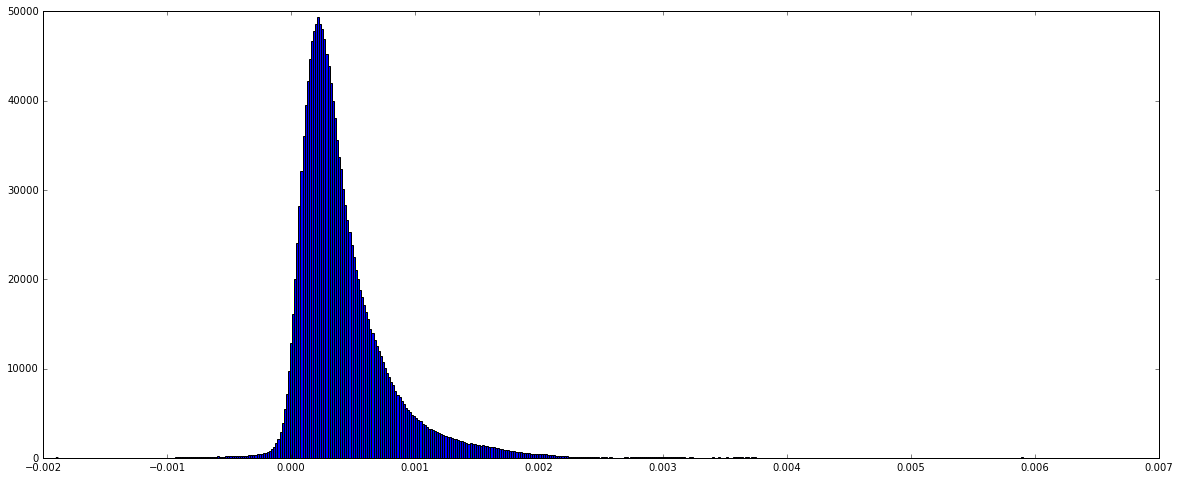

In [36]:
plt.rcParams["figure.figsize"] = [20.0,8.0]
a = hist(lpp_values, bins=500)


In [44]:
print(a[1][170])

0.00096785915213


In [38]:
conn = sqlite3.connect('matti_eeg.db')
c = conn.cursor()

In [39]:
# Create table
c.execute('''CREATE TABLE data
             (
             channel0 real, 
             channel1 real, 
             channel2 real, 
             channel3 real, 
             channel4 real, 
             channel5 real, 
             channel6 real, 
             channel7 real, 
             channel8 real, 
             channel9 real, 
             lpp real)''')

In [40]:
channels = []
for value_index in range(len(data[0])):
    all_channels = []
    for channel_index in range(10):
        all_channels.append(data[channel_index][value_index])
    all_channels.append(lpp_values[value_index])
        
    channels.append(tuple(all_channels))      
    
    
#channel0 = map(lambda x: (0,x), data[0])


In [41]:
#print(data[1][1])

In [42]:
c.executemany('INSERT INTO data VALUES (?,?,?,?,?,?,?,?,?,?,?)', channels)

In [43]:
conn.commit()
conn.close()